<a href="https://colab.research.google.com/github/jo49973477/naverblog/blob/main/AlexNet_Running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration

In [ ]:
config = {
    'batch_size': 16,
    'learning rate': 1e-3,
    'epoch': 10,
    'DEVICE': "cuda" if torch.cuda.is_available() else "cpu",
    'lambda': 0.0005,
}

print(config['DEVICE'])

cuda


# 2. Loading the Dataset
## Loading the Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(227),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=config['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Image Example Showing

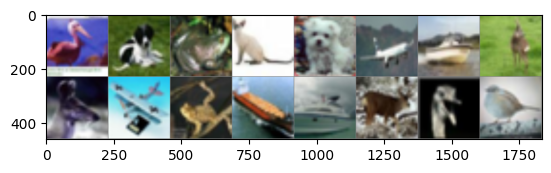

bird  dog   frog  cat   dog   plane ship  deer  deer  plane frog  ship  ship  deer  bird  bird 
Image Size: torch.Size([3, 227, 227])


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(config['batch_size'])))

C, H, W = images[0].shape
print("Image Size: {}".format(images[0].shape))

# 2. Model:: AlexNet

In [ ]:
class AlexNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 그림에 묘사된 건 96개의 채널이 있으먄 GPU 1개에서 48개 48개로 쪼개서 연산하는 것임

        self.layer1 = torch.nn.Sequential( # CONV1
            torch.nn.Conv2d(in_channels, 96, kernel_size=11, stride=4), # conv1, 32*32*3 -> 55*55*96
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2) # 55*55*96 -> 27*27*96
        )

        self.layer2 = torch.nn.Sequential( # CONV2
            torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # 27*27*96 -> 27*27*256
            torch.nn.ReLU(inplace=True),
            torch.nn.LocalResponseNorm(2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2) #13*13*256
        )

        self.layer3 = torch.nn.Sequential( #CONV3
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), #13*13*256 -> 13*13*384
            torch.nn.ReLU(inplace=True)
        )

        self.layer4 = torch.nn.Sequential( #CONV4
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1), #13*13*384 -> 13*13*384
            torch.nn.ReLU(inplace=True)
        )

        self.layer5 = torch.nn.Sequential( #CONV5
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=2, padding=0), #13*13*384 -> 13*13*256
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1) #6*6*256
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(6*6*256, 4096), # fc1
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096), # fc2
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes) # fc3
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# 3. Running Model

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
model = AlexNet(in_channels=3, num_classes=len(classes))
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning rate'], weight_decay = config['lambda'])
criterion = nn.CrossEntropyLoss().to(config['DEVICE'])

print("Device:  ", config['DEVICE'])
summary(model, input_size=(config['batch_size'], C, H, W))

Device:   cuda


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 10]                  --
├─Sequential: 1-1                        [16, 96, 27, 27]          --
│    └─Conv2d: 2-1                       [16, 96, 55, 55]          34,944
│    └─ReLU: 2-2                         [16, 96, 55, 55]          --
│    └─LocalResponseNorm: 2-3            [16, 96, 55, 55]          --
│    └─MaxPool2d: 2-4                    [16, 96, 27, 27]          --
├─Sequential: 1-2                        [16, 256, 13, 13]         --
│    └─Conv2d: 2-5                       [16, 256, 27, 27]         614,656
│    └─ReLU: 2-6                         [16, 256, 27, 27]         --
│    └─LocalResponseNorm: 2-7            [16, 256, 27, 27]         --
│    └─MaxPool2d: 2-8                    [16, 256, 13, 13]         --
├─Sequential: 1-3                        [16, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [16, 384, 13, 13]         885,120
│

In [ ]:

total_train_loss = []
total_train_acc = []
test_losses = []
test_accuracy = []
learning_rate_tracker = []

for epoch in range(1, config['epoch']+1):

    train_losses   = []
    train_accuracy = []
    model.train()

    for i, batch in enumerate(trainloader):
          #Extract data, labels
        img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        #Train model
        optimizer.zero_grad()
        output = model(img_batch) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)
        train_losses.append(loss.item())
        train_accuracy.append(acc.cpu())

        # Update global metrics
        total_loss = np.mean(train_losses)
        total_acc = np.mean(train_accuracy)
        total_train_loss.append(total_loss)
        total_train_acc.append(total_acc)


        #Just checking...
        if i % 300 == 0:
            print(f'Train Epoch: {epoch}, batch: {i}/{len(trainloader)} | Batch metrics | loss: {total_loss:.4f}, accuracy: {total_acc:.3f}')

        #Update learning rate
        learning_rate_tracker.append(optimizer.state_dict()['param_groups'][0]['lr'])

    model.eval()
    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(testloader):
        img_batch, label_batch = batch
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        output = model(img_batch) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)

        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)

        total_loss += loss.item()
        total_acc += acc.cpu()

    total_loss /= len(testloader)
    total_acc /= len(testloader)

    test_losses.append(total_loss)
    test_accuracy.append(total_acc)

    print(f"----EPOCH{epoch} TEST----")
    print(f"LOSS: {total_loss:.4f} | ACCURACY : {total_acc:.3f}")

Train Epoch: 1, batch: 0/3125 | Batch metrics | loss: 2.3010, accuracy: 0.250
Train Epoch: 1, batch: 300/3125 | Batch metrics | loss: 2.1921, accuracy: 0.165
Train Epoch: 1, batch: 600/3125 | Batch metrics | loss: 2.1207, accuracy: 0.199
Train Epoch: 1, batch: 900/3125 | Batch metrics | loss: 2.0905, accuracy: 0.212
Train Epoch: 1, batch: 1200/3125 | Batch metrics | loss: 2.0604, accuracy: 0.223
Train Epoch: 1, batch: 1500/3125 | Batch metrics | loss: 2.0409, accuracy: 0.229
Train Epoch: 1, batch: 1800/3125 | Batch metrics | loss: 2.0202, accuracy: 0.239
Train Epoch: 1, batch: 2100/3125 | Batch metrics | loss: 2.0030, accuracy: 0.245
Train Epoch: 1, batch: 2400/3125 | Batch metrics | loss: 1.9842, accuracy: 0.253
Train Epoch: 1, batch: 2700/3125 | Batch metrics | loss: 1.9679, accuracy: 0.260
Train Epoch: 1, batch: 3000/3125 | Batch metrics | loss: 1.9539, accuracy: 0.266
----EPOCH1 TEST----
LOSS: 1.6753 | ACCURACY : 0.371
Train Epoch: 2, batch: 0/3125 | Batch metrics | loss: 1.5906, a

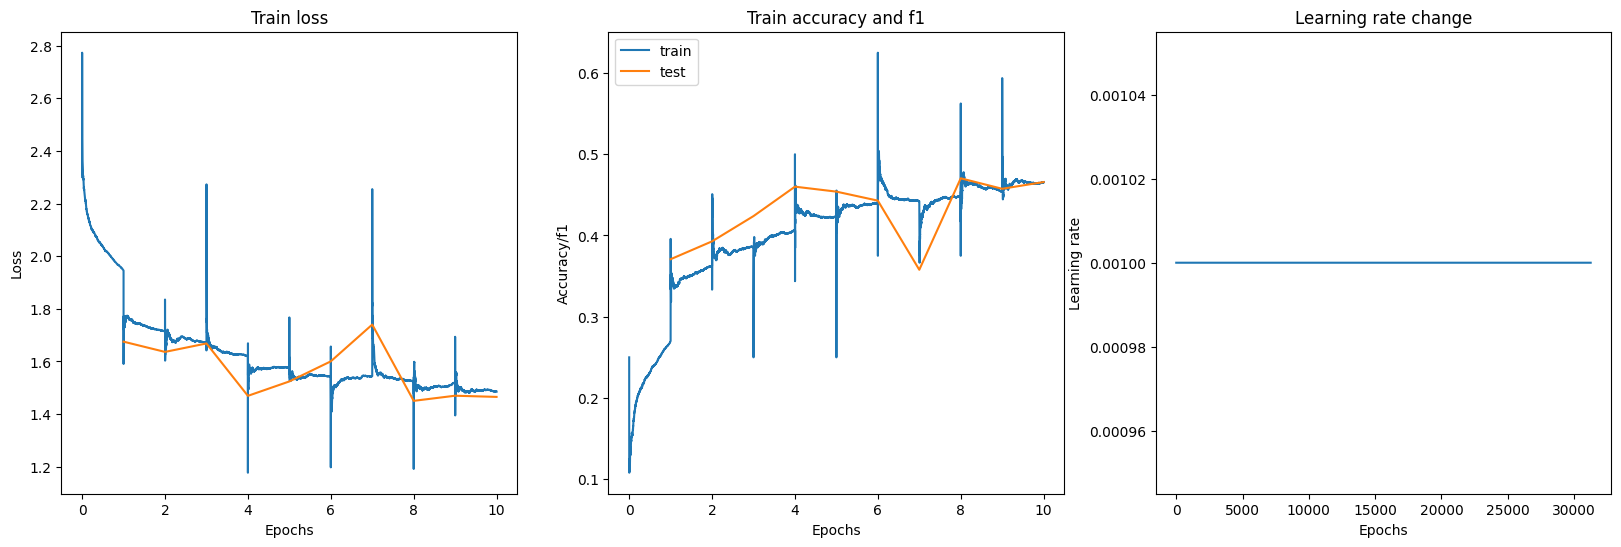

In [ ]:
train_x = np.linspace(0, config['epoch'], len(trainloader) * config['epoch'])
test_x = np.arange(1, config['epoch']+1)

f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(train_x, total_train_loss, label='train')
axarr[0].plot(test_x, test_losses, label='test')
axarr[0].set_title('Train loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(train_x, total_train_acc, label='train')
axarr[1].plot(test_x, test_accuracy, label='test')
axarr[1].set_title('Train accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(learning_rate_tracker)), learning_rate_tracker)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')

plt.show()